In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModel
transformers.logging.set_verbosity_error()

import re
from glob import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import argparse
# import wandb
# from wandb.keras import WandbCallback
# wandb.init(project="DACON_235978", name="gnoeyheat")

parser = argparse.ArgumentParser(description="gnoeyheat")
parser.add_argument('--text_pretrained_model', default="roberta", type=str)
parser.add_argument('--text_len', default=300, type=int)
parser.add_argument('--optimizer', default="sgd", type=str) # sgd or adam
parser.add_argument('--learning_rate', default=0.002, type=float)
parser.add_argument('--loss', default='cc', type=str) # cc or fl
parser.add_argument('--label_smoothing', default=0.1, type=float)
parser.add_argument('--batch_size', default=6, type=int)
parser.add_argument('--epochs', default=30, type=int)
parser.add_argument('--validation_split', default=0.1, type=float)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

# wandb.config.update(args)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

text_pretrained_model = args.text_pretrained_model
text_len = args.text_len

BATCH_SIZE=args.batch_size
EPOCHS=args.epochs
VALIDATION_SPLIT=args.validation_split
SEED=args.seed

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

In [2]:
# !pip install tensorflow_addons
# !pip install transformers

In [3]:
if args.text_pretrained_model == "roberta":
    text_pretrained_model = "klue/roberta-large"
    
tokenizer = AutoTokenizer.from_pretrained(text_pretrained_model)
# tokenizer.truncation_side = 'left'

In [4]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

X_txt = train["overview"]
X_test_txt = test["overview"]

y = train["cat3"]
y_encoder = {key : value for key, value in zip(np.unique(y), range(len(np.unique(y))))}
y = np.array([y_encoder[k] for k in y])

X_txt.shape, X_test_txt.shape, y.shape

((16986,), (7280,), (16986,))

In [5]:
def text_cleaning(df):
    df = df.apply(lambda x : re.sub('[^ ㄱ-ㅣ가-힣]+', ' ', x))
    df = df.apply(lambda x : ' '.join(x.split()))
    return df

X_txt = text_cleaning(X_txt)
X_test_txt = text_cleaning(X_test_txt)

X_txt.iloc[0]

'소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 올리고 있으며 바다낚시터로도 유명하다 항 주변에 설치된 양식장들은 섬사람들의 부지런한 생활상을 고스 란히 담고 있으며 일몰 때 섬의 정경은 바다의 아름다움을 그대로 품고 있는 듯하다 또한 섬에는 각시여 전설 도둑바위 등의 설화가 전해 내려오고 있으며 매년 정월 풍어제 풍속이 이어지고 있다'

In [6]:
train["len"] = train["overview"].apply(tokenizer.tokenize).apply(len)
test["len"] = test["overview"].apply(tokenizer.tokenize).apply(len)
train["len"].median(), test["len"].median()

(144.0, 144.0)

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(
        self,
        sentence,
        labels,
        batch_size=BATCH_SIZE,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence = sentence
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        self.tokenizer = tokenizer
        self.indexes = np.arange(len(self.sentence))
        self.on_epoch_end()

    def __len__(self):
        return len(self.sentence) // self.batch_size

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence = self.sentence[indexes]

        encoded = self.tokenizer.batch_encode_plus(
            sentence.tolist(),
            add_special_tokens=True,
            padding="max_length",
            truncation=True,
            max_length=text_len,
            return_tensors="tf",
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.RandomState(SEED).shuffle(self.indexes)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_txt, y, test_size=VALIDATION_SPLIT, random_state=SEED, stratify=y)

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((15287,), (1699,), (15287, 128), (1699, 128))

In [9]:
train_ds = DataGenerator(
    X_train.values, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_ds = DataGenerator(
    X_val.values, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [10]:
input_ids = tf.keras.layers.Input(
    shape=(text_len,), dtype=tf.int32, name="input_ids"
)
attention_masks = tf.keras.layers.Input(
    shape=(text_len,), dtype=tf.int32, name="attention_masks"
)
token_type_ids = tf.keras.layers.Input(
    shape=(text_len,), dtype=tf.int32, name="token_type_ids"
)

bert_model = TFAutoModel.from_pretrained(text_pretrained_model, from_pt=True)
bert_model.trainable = True

bert_output = bert_model(
    input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
)

x = bert_output.last_hidden_state
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(y_train.shape[1], activation="softmax")(x)

model = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

In [11]:
if args.optimizer == "sgd":
    optim = tf.keras.optimizers.SGD(
        learning_rate=args.learning_rate, momentum=0.9
    )
if args.loss == "cc": 
  # 정답이 원-핫 형태로 주어지도록
    loss_function = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=args.label_smoothing
    )

model.compile(
    optimizer=optim,
    loss=loss_function,
    metrics=tfa.metrics.F1Score(num_classes=y_train.shape[1], average="weighted")
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 300)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  336656384  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_masks[0][0]',    

In [12]:
checkpoint_path = f"load_model/{parser.description}"

# 감소 스케쥴러
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = [
    tf.keras.callbacks.LearningRateScheduler(scheduler)
    # tf.keras.callbacks.ModelCheckpoint(
        # checkpoint_path,
        # monitor="val_f1_score",
        # save_best_only=True,
        # save_weights_only=True,
        # mode="max",
    # )
]

history = model.fit(
    train_ds,
    epochs=2,
    callbacks=[callback],
    validation_data=val_ds,
)
#그러기엔 loss가 높다
# tf.Variable 'dense_3/kernel: 이름의 문제 같은데? 일단 존재하는것도 확인했따
# tf_roberta_model_3/roberta/pooler/dense/kernel:0가 .
# 맨 마지막엔 tf.Variable 'dense_3/kernel:0' 그냥 이거다. roberta model pooler 안의 dense가 문제있는것
# 컴퓨팅 파워가 부족해서 , batch_Size 그마한차이가 그렇게 큰 차이인지몰라서?
# tf_roberta_model_3/roberta/pooler/dense/kernel:0
# learnigng_rate 낮추니까 더 상승하긴하는데 batch_size 때문인가 , 어떻게 그런 차이로 된다고
#소중한 답변 감사드립니다.

Epoch 1/2


ResourceExhaustedError:  OOM when allocating tensor with shape[6,16,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/tf_roberta_model/roberta/encoder/layer_._16/attention/self/Softmax
 (defined at C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\tf_utils.py:70)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_50677]

Errors may have originated from an input operation.
Input Source operations connected to node model/tf_roberta_model/roberta/encoder/layer_._16/attention/self/Softmax:
In[0] model/tf_roberta_model/roberta/encoder/layer_._16/attention/self/add_1:

Operation defined at: (most recent call last)
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
>>>     res = shell.run_cell(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\DATA\AppData\Local\Temp\ipykernel_15684\2946716243.py", line 21, in <cell line: 21>
>>>     history = model.fit(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\modeling_tf_utils.py", line 946, in run_call_with_unpacked_inputs
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 974, in call
>>>     outputs = self.roberta(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\modeling_tf_utils.py", line 946, in run_call_with_unpacked_inputs
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 747, in call
>>>     encoder_outputs = self.encoder(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 538, in call
>>>     for i, layer_module in enumerate(self.layer):
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 544, in call
>>>     layer_outputs = layer_module(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 453, in call
>>>     self_attention_outputs = self.attention(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 366, in call
>>>     self_outputs = self.self_attention(
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\data\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\models\roberta\modeling_tf_roberta.py", line 303, in call
>>>     attention_probs = stable_softmax(logits=attention_scores, axis=-1)
>>> 
>>>   File "C:\Users\DATA\AppData\Roaming\Python\Python38\site-packages\transformers\tf_utils.py", line 70, in stable_softmax
>>>     return tf.nn.softmax(logits=logits + 1e-9, axis=axis, name=name)
>>> 

In [13]:
# 3080도 ramb이 10gb 밖에안되네

!nvidia-smi

Thu Nov  3 14:57:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   30C    P8    11W / 340W |   8048MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# 
# batch_size에 따라 크게달라질 수있나

model.fit([sentences['input_ids'][6:10], sentences['attention_mask'][6:10], sentences['token_type_ids'][6:10]], y_train[indexes][6:10])
#  ['tf_roberta_model_4/roberta/pooler/dense/kernel:0', 4번째 만들어서? memory 에 존재해서 ?  저 숫자가 늘어나는데

In [ ]:

model.trainable_variables

[<tf.Variable 'tf_roberta_model_3/roberta/encoder/layer_._0/attention/self/query/kernel:0' shape=(1024, 1024) dtype=float32, numpy=
 array([[ 0.0250899 , -0.01506593, -0.01592501, ...,  0.02149598,
         -0.02403606, -0.00192892],
        [ 0.02750163, -0.00469995,  0.02719743, ..., -0.03388865,
         -0.02928514,  0.037274  ],
        [-0.03786054, -0.05661793, -0.00160929, ...,  0.03531896,
          0.01254691, -0.02955021],
        ...,
        [-0.02924649,  0.00102879,  0.00725678, ...,  0.08179005,
          0.02084669, -0.0251829 ],
        [ 0.00615401,  0.03321097, -0.00447317, ..., -0.02212346,
         -0.00689882, -0.00524832],
        [-0.03517796,  0.02683576, -0.01413629, ...,  0.02812676,
          0.03108056, -0.03604174]], dtype=float32)>,
 <tf.Variable 'tf_roberta_model_3/roberta/encoder/layer_._0/attention/self/query/bias:0' shape=(1024,) dtype=float32, numpy=
 array([-0.24599898,  0.14388181,  0.07613993, ...,  0.00585116,
         0.08408851,  0.04920534], 

In [ ]:
# 모델의 모든 학습가능한 가중치들 
len(model.trainable_variables)

393

In [ ]:
# ctrl+space 자동완성 
tokenizer.vocab


{'고흐': 22153,
 '썬': 1347,
 '바닷속': 27200,
 '한미': 7608,
 '##촬': 2637,
 '진화': 6747,
 '잣': 1524,
 '개혁': 4413,
 '락': 943,
 '장신': 16765,
 '시': 1325,
 '##아리움': 31418,
 '좌중': 29625,
 '긁': 640,
 '##바': 2100,
 '증오': 11855,
 '교과서': 6056,
 '뒤졌': 22675,
 '한상': 13196,
 '##화': 2267,
 '##㎏': 3597,
 '어지럼': 29377,
 'ㆍ장': 25264,
 '##연합': 8948,
 '비나': 30264,
 '장단': 10890,
 '1919': 18548,
 '부천시': 18885,
 '부산시': 7767,
 '구급': 14922,
 '글라스': 20177,
 '샷': 1255,
 '납입': 12064,
 '트레일': 30984,
 '줬': 1572,
 '##전등': 31330,
 '겉모습': 24159,
 '피크': 13467,
 '정성': 6913,
 '인용': 6427,
 '뒤쪽': 12101,
 '의외': 8797,
 '살인범': 24080,
 '##파이': 11822,
 '##섰': 3074,
 '고양시': 10978,
 '[unused221]': 31721,
 '오브': 10257,
 '##려면': 19644,
 '서도': 21245,
 '에어컨': 9413,
 '선재': 29064,
 '##영상': 6848,
 '오랫': 6311,
 '##스틴': 13439,
 '전라도': 14329,
 '노프': 31172,
 '가라': 8335,
 '넘쳐나': 18992,
 '야스': 16027,
 '불타': 13404,
 '끌려': 9001,
 '안식': 16469,
 '필수품': 22953,
 '스쿨': 9705,
 '그래야': 8741,
 '와이': 8003,
 '시위': 5754,
 '아이디': 15129,
 '최소한': 6820,
 '경각심': 2305

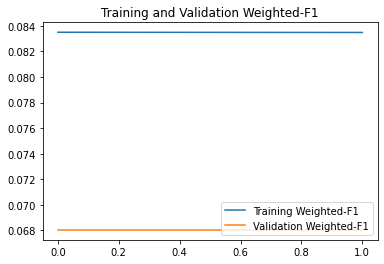

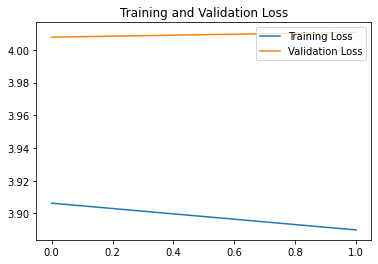

In [ ]:
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training Weighted-F1')
plt.plot(val_acc, label='Validation Weighted-F1')
plt.legend(loc='lower right')
plt.title('Training and Validation Weighted-F1')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
val_weighted_f1 = model.evaluate(val_ds)[1]
print(f"val_weighted_f1: {val_weighted_f1}")

106/106 [==============================] - 14s 130ms/step - loss: 4.0078 - f1_score: 0.0680
val_weighted_f1: 0.06804170459508896


In [ ]:
# 값 자제가 거의 변화가 없다

In [ ]:
test_ds.__getitem__(16)

[array([[    0,  4132, 10171, ...,     1,     1,     1],
        [    0,  1087,  2437, ...,     1,     1,     1],
        [    0,  1933,  2019, ...,     1,     1,     1],
        ...,
        [    0, 20396,  2242, ...,     1,     1,     1],
        [    0,  7749,  2588, ...,     1,     1,     1],
        [    0,   591,  2335, ...,     1,     1,     1]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]

In [ ]:
test_ds.__getitem__(31)

[array([[    0,  4573, 10526, ...,     1,     1,     1],
        [    0,  1268,  2047, ..., 12298,  2170,     2],
        [    0,  6546,  2733, ...,     1,     1,     1],
        ...,
        [    0,  1086,  2284, ...,     1,     1,     1],
        [    0,  3671, 27135, ...,     1,     1,     1],
        [    0, 14017, 12007, ...,     1,     1,     1]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]

In [ ]:
# 값자체에 변화가 너무없다 왜지 가중치 학습 자체가 잘 안되는 듯 한데
pred_prob[30]

array([[0.00888866, 0.00105247, 0.00109652, ..., 0.00219239, 0.00381442,
        0.00370858],
       [0.00888859, 0.00105248, 0.00109654, ..., 0.00219241, 0.00381446,
        0.00370855],
       [0.00888865, 0.00105246, 0.00109653, ..., 0.00219242, 0.00381443,
        0.00370855],
       ...,
       [0.00888873, 0.00105244, 0.00109649, ..., 0.00219233, 0.00381429,
        0.00370851],
       [0.00888867, 0.00105247, 0.00109653, ..., 0.0021924 , 0.00381444,
        0.00370849],
       [0.00888865, 0.00105247, 0.00109654, ..., 0.00219243, 0.00381444,
        0.00370852]], dtype=float32)

In [ ]:

pred_prob[16]

array([[0.00888864, 0.00105244, 0.00109651, ..., 0.00219233, 0.00381424,
        0.00370839],
       [0.00888867, 0.00105247, 0.00109654, ..., 0.00219242, 0.00381444,
        0.00370852],
       [0.0088889 , 0.00105246, 0.00109656, ..., 0.00219246, 0.00381441,
        0.00370845],
       ...,
       [0.00888863, 0.00105248, 0.00109653, ..., 0.00219241, 0.00381443,
        0.00370853],
       [0.00888867, 0.00105248, 0.00109653, ..., 0.00219243, 0.00381446,
        0.00370857],
       [0.00888881, 0.00105247, 0.00109651, ..., 0.00219242, 0.00381441,
        0.00370849]], dtype=float32)

In [ ]:
test_ds = DataGenerator(
    X_test_txt.values, None,
    batch_size=4,
    shuffle=False,
    include_targets=False,
)

pred_prob = []
for i in range(test_ds.__len__()):
    pred_prob.append(model.predict(test_ds.__getitem__(i)))
pred_prob = np.vstack(pred_prob)
pred = np.argmax(pred_prob, axis=1)

y_decoder = {value : key for key, value in y_encoder.items()}
result = np.array([y_decoder[v] for v in pred])

pd.Series(result).value_counts()

1/1 [==============================] - 0s 142ms/step


KeyboardInterrupt: ignored

In [ ]:
submission = pd.read_csv("./sample_submission.csv")
submission["cat3"] = result
submission.to_csv(f"{parser.description}.csv", index=False)

In [ ]:
result

array(['한식', '한식', '한식', ..., '한식', '한식', '한식'], dtype='<U2')

In [ ]:
bb

In [ ]:
a

In [ ]:
y_pred = model.predict(train_ds)

955/955 [==============================] - 123s 129ms/step


In [ ]:
y_pred.shape


(15280, 128)

In [ ]:
y_train.shape


(15287, 128)

In [ ]:


tf.math.argmax(y_pred[0])

<tf.Tensor: shape=(), dtype=int64, numpy=118>

In [ ]:

tf.math.argmax(y_train[0])

<tf.Tensor: shape=(), dtype=int64, numpy=73>

In [ ]:


tf.math.argmax(y_pred[1])


<tf.Tensor: shape=(), dtype=int64, numpy=118>

In [ ]:


tf.math.argmax(y_train[1])

<tf.Tensor: shape=(), dtype=int64, numpy=91>

In [ ]:
tf.math.argmax(y_pred[0])

<tf.Tensor: shape=(), dtype=int64, numpy=118>

In [ ]:
tf.math.argmax(y_val[0])


<tf.Tensor: shape=(), dtype=int64, numpy=85>

In [ ]:
tf.math.argmax(y_pred[1])

<tf.Tensor: shape=(), dtype=int64, numpy=118>

In [ ]:
tf.math.argmax(y_val[1])


<tf.Tensor: shape=(), dtype=int64, numpy=84>

In [ ]:
model.predict(X_val)

ValueError: ignored

In [ ]:
#혹시 f1_score는 0.1 이지만 (아무래도 클래스가 128이니까)
# 어느정도 예측은 하는건가